In [ ]:
'''
  this part is responsible for the mounting of data from the drive into the
  notebook and retrieving the dataset
'''
from google.colab import drive
drive.mount('/content/drive/')

!cp './drive/My Drive/Graduation project/Dataset.zip' /content
!unzip ./Dataset.zip


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Archive:  ./Dataset.zip
  inflating: 1.mpg                   
  inflating: 10.mpg                  
  inflating: 100.mpg                 
  inflating: 11.mpg                  
  inflating: 12 (1).mpg              
  inflating: 13.mpg                  
  inflating: 14.mpg                  
  inflating: 15.mpg                  
  inflating: 16.mpg                  
  inflating: 17.mpg                  
  inflating: 18.mpg                  
  inflating: 19.mpg  

In [ ]:
'''
  This part contains the used libraries and essintial parameters
  such as frames and dimensions
'''
!pip install scikit-video
#Used Libraries
import time
import sys
import pandas as pd
import numpy as np
import cv2
import pickle
import skvideo.io
import h5py
from tables import *
from sklearn import metrics
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.layers import LSTM , Dense , TimeDistributed, Flatten, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Reshape, BatchNormalization ,ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , RMSprop, SGD

#Parameters
NUMBER_OF_FRAMES = 20
IMAGE_SIZE = 160
IMAGE_CHANNELS = 3

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [ ]:
'''
  This part is responsible for reading the fight and no fight
  data from the hockey dataset
'''
dtframe = pd.DataFrame()
vid = []
lab = []
for i in range(500):
  vid.append("fi"+ str(i+1) +"_xvid.avi")
  lab.append(1)
  vid.append("no"+ str(i+1) +"_xvid.avi")
  lab.append(0)
dtframe['video_name'] = vid
dtframe['tag'] = lab
dtframe.head

<bound method NDFrame.head of          video_name  tag
0      fi1_xvid.avi    1
1      no1_xvid.avi    0
2      fi2_xvid.avi    1
3      no2_xvid.avi    0
4      fi3_xvid.avi    1
..              ...  ...
995  no498_xvid.avi    0
996  fi499_xvid.avi    1
997  no499_xvid.avi    0
998  fi500_xvid.avi    1
999  no500_xvid.avi    0

[1000 rows x 2 columns]>

In [ ]:
'''
  This part is responsible for reading the fight and no fight
  data from the movies dataset
'''
dtframe2 = pd.DataFrame()
vid2 = []
lab2 = []
for i in range(100):
  vid2.append("newfi"+ str(i+1) +".avi")
  lab2.append(1)
  vid2.append(str(i+1) +".mpg")
  lab2.append(0)
dtframe2['video_name'] = vid2
dtframe2['tag'] = lab2
dtframe2.head

<bound method NDFrame.head of        video_name  tag
0      newfi1.avi    1
1           1.mpg    0
2      newfi2.avi    1
3           2.mpg    0
4      newfi3.avi    1
..            ...  ...
195        98.mpg    0
196   newfi99.avi    1
197        99.mpg    0
198  newfi100.avi    1
199       100.mpg    0

[200 rows x 2 columns]>

In [ ]:
'''
  This part is responsible for shuffling and seperating the data into train and
  validate. Both splits are balanced # Fight = # No Fight
'''
traindf = dtframe[:100]
traindf = traindf.append(dtframe2[:150],ignore_index= True)
valdf = dtframe[101:151]
valdf = valdf.append(dtframe2[151:189], ignore_index= True)
traindf = traindf.sample(frac=1).reset_index(drop=True)
valdf = valdf.sample(frac=1).reset_index(drop=True)

In [ ]:
'''
  This part is responsible for the cropping of the black frames from the videos
'''
def autocrop(image, threshold=0):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

In [ ]:
'''
  This part is responsible for resizing and scaling each frame of a video
  - changing the image from BGR to RGB
  - the scaling is from 0 to 1 by dividing each pixel value by 255
  - resizing the images to the expected size in the parameters 
  - applying the autocrop method
'''

def scale_and_resize(image):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = autocrop(image)
  image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
  image = image/255.0
  
  return image.astype('float16')
  

In [ ]:
'''
  Input parameter: Dataframe contains Video name and label
  Output: tensor of (SAMPLES,20,160,160,3) contains videos divided into frames
'''
def extract_frames(videodf, start_index = 0, end_index =-1):

  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]

  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = np.zeros((NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))

    for j in range(NUMBER_OF_FRAMES):
      new_images[j] = scale_and_resize(videodata[j*steps])

    output_videos.append(new_images)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [ ]:
'''
  Input parameter: Dataframe contains Video name and label
  Output: tensor of (SAMPLES,10,160,160,3) contains videos divided into 
  difference between frames
'''
def extract_frames_difference(videodf, start_index = 0, end_index =-1):
  
  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]

  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = []
    new_diff = np.zeros((int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
    count = 0

    for j in range(NUMBER_OF_FRAMES):
      new_images.append(videodata[j*steps])

    for j in range(0,NUMBER_OF_FRAMES,2):
      new_diff[count] = scale_and_resize(cv2.absdiff(new_images[j],new_images[j+1]))
      count += 1 

    output_videos.append(new_diff)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [ ]:
fvideo , flabels = extract_frames(traindf)

Video Processed 250/250

In [ ]:
tvideo , tlabels = extract_frames(valdf)

Video Processed 88/88

In [ ]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [ ]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

(240, 20, 160, 160, 3)
(240,)
(87, 20, 160, 160, 3)
(87,)


In [ ]:
hockey_video , hockey_labels = extract_frames(dtframe,300,400)

Video Processed 100/100

In [ ]:
movies_video , movies_labels = extract_frames(dtframe2,189,199)

Video Processed 10/10

In [ ]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

(100, 20, 160, 160, 3)
(100,)
(10, 20, 160, 160, 3)
(10,)


In [ ]:
'''
  This algorithm uses the history data from the training of the model (.fit)
  in order to plot the loss and accuracy at each epoch
'''
def plot_results(history):  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.legend()

  plt.show()
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()

  plt.show()

In [ ]:
'''
  This method is responsible to evaluate a model which is passed as a 
  parameter to test it on both hockey and movies dataset
'''
def val_results(model):
  hockey_predictions = []

  for i in range(0,len(hockey_video)):
    hockey_predictions.append(model.predict(hockey_video[i:i+1])[0])

  count = 0
  count2 = 0

  for i in range(len(hockey_labels)):
    if hockey_predictions[i] > 0.5 and hockey_labels[i] == 1:
      count +=1 
    elif hockey_predictions[i] < 0.5 and hockey_labels[i] == 0:
      count +=1

  movies_predictions = model.predict(movies_video)

  for i in range(len(movies_labels)):
    if movies_predictions[i] > 0.5 and movies_labels[i] == 1:
      count2 +=1 
    elif movies_predictions[i] < 0.5 and movies_labels[i] == 0:
      count2 +=1 
  print("Hockey Test Acc: " , float(count/len(hockey_labels)),"\tCount: " , count ,"\nMovies Test Acc: " ,float(count2/len(movies_labels)),"\tCount: " , count2)

In [ ]:
'''
  Defining the first model which uses the full frames to classify the action
'''
def CNN_LSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,3)
    #np.random.seed(1234)
    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    model = Sequential()
    #model.add(Input(shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(cnn)
    model.add(TimeDistributed(Flatten()))

    
    model.add(LSTM(NUMBER_OF_FRAMES+80 , return_sequences= True))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(90, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
vgg_adam_retrain = CNN_LSTM('Vgg19', 'Adam', True)
vgg_adam_retrain_history = vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 22s 929ms/step - loss: 0.6473 - accuracy: 0.6375 - val_loss: 0.6536 - val_accuracy: 0.7011
Epoch 2/20
24/24 [==============================] - 22s 897ms/step - loss: 0.4610 - accuracy: 0.8000 - val_loss: 0.6539 - val_accuracy: 0.5977
Epoch 3/20
24/24 [==============================] - 22s 897ms/step - loss: 0.3771 - accuracy: 0.8500 - val_loss: 0.6264 - val_accuracy: 0.7931
Epoch 4/20
24/24 [==============================] - 22s 897ms/step - loss: 0.3646 - accuracy: 0.8417 - val_loss: 0.5937 - val_accuracy: 0.8161
Epoch 5/20
24/24 [==============================] - 22s 919ms/step - loss: 0.3538 - accuracy: 0.8667 - val_loss: 0.5721 - val_accuracy: 0.8736
Epoch 6/20
24/24 [==============================] - 22s 896ms/step - loss: 0.3589 - accuracy: 0.8333 - val_loss: 0.6138 - val_accuracy: 0.6437
Epoch 7/20
24/24 [==============================] - 22s 897ms/step - loss: 0.2747 - accuracy: 0.9042 - val_loss: 0.5769 - val_accuracy: 0.7241

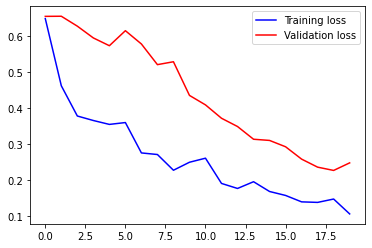

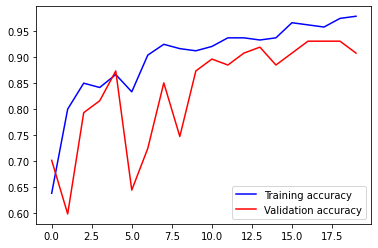

In [ ]:
plot_results(vgg_adam_retrain_history)

In [ ]:
val_results(vgg_adam_retrain)

Hockey Test Acc:  0.83 	Count:  83 
Movies Test Acc:  1.0 	Count:  10


In [ ]:
vgg_adam_static = CNN_LSTM('Vgg19', 'Adam', False)
vgg_adam_static_history = vgg_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 11s 474ms/step - loss: 0.7992 - accuracy: 0.5083 - val_loss: 0.6912 - val_accuracy: 0.5172
Epoch 2/20
24/24 [==============================] - 10s 403ms/step - loss: 0.6506 - accuracy: 0.6417 - val_loss: 0.6740 - val_accuracy: 0.6207
Epoch 3/20
24/24 [==============================] - 10s 403ms/step - loss: 0.4696 - accuracy: 0.7833 - val_loss: 0.6632 - val_accuracy: 0.6322
Epoch 4/20
24/24 [==============================] - 10s 403ms/step - loss: 0.4717 - accuracy: 0.7750 - val_loss: 0.6589 - val_accuracy: 0.5977
Epoch 5/20
24/24 [==============================] - 10s 402ms/step - loss: 0.4496 - accuracy: 0.8083 - val_loss: 0.6483 - val_accuracy: 0.6092
Epoch 6/20
24/24 [==============================] - 10s 403ms/step - loss: 0.3687 - accuracy: 0.8458 - val_loss: 0.6252 - val_accuracy: 0.6322
Epoch 7/20
24/24 [==============================] - 10s 406ms/step - loss: 0.3667 - accuracy: 0.8625 - val_loss: 0.6109 - val_accuracy: 0.5862

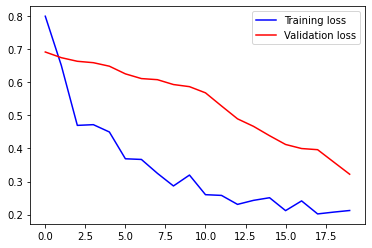

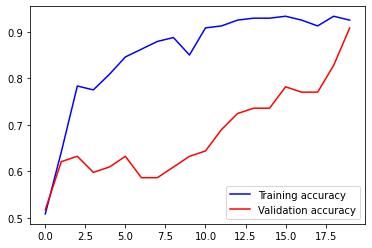

In [ ]:
plot_results(vgg_adam_static_history)

In [ ]:
val_results(vgg_adam_static)

Hockey Test Acc:  0.8 	Count:  80 
Movies Test Acc:  1.0 	Count:  10


In [ ]:
resnet_adam_static = CNN_LSTM('Resnet', 'Adam', False)
resnet_adam_static_history = resnet_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 8s 324ms/step - loss: 0.7994 - accuracy: 0.5750 - val_loss: 0.7063 - val_accuracy: 0.5057
Epoch 2/20
24/24 [==============================] - 6s 248ms/step - loss: 0.7057 - accuracy: 0.6375 - val_loss: 0.7009 - val_accuracy: 0.5057
Epoch 3/20
24/24 [==============================] - 6s 249ms/step - loss: 0.6757 - accuracy: 0.6042 - val_loss: 0.6844 - val_accuracy: 0.5057
Epoch 4/20
24/24 [==============================] - 6s 249ms/step - loss: 0.5547 - accuracy: 0.7083 - val_loss: 0.6778 - val_accuracy: 0.5057
Epoch 5/20
24/24 [==============================] - 6s 254ms/step - loss: 0.5601 - accuracy: 0.7042 - val_loss: 0.6687 - val_accuracy: 0.5977
Epoch 6/20
24/24 [==============================] - 6s 247ms/step - loss: 0.5863 - accuracy: 0.7333 - val_loss: 0.6598 - val_accuracy: 0.5977
Epoch 7/20
24/24 [==============================] - 6s 255ms/step - loss: 0.5277 - accuracy: 0.7750 - val_loss: 0.6624 - val_accuracy: 0.6092
Epoch 

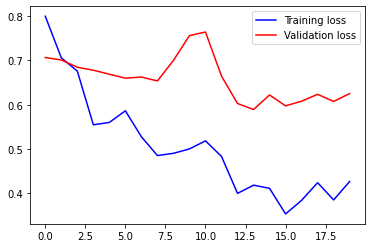

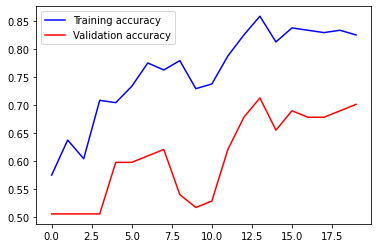

In [ ]:
plot_results(resnet_adam_static_history)

In [ ]:
val_results(resnet_adam_static)

Hockey Test Acc:  0.77 	Count:  77 
Movies Test Acc:  0.6 	Count:  6


In [ ]:
resnet_rmsprop_static = CNN_LSTM('Resnet', 'RMSprop', False)
resnet_rmsprop_static_history = resnet_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 8s 313ms/step - loss: 0.6074 - accuracy: 0.7125 - val_loss: 0.6879 - val_accuracy: 0.5632
Epoch 2/20
24/24 [==============================] - 6s 250ms/step - loss: 0.5521 - accuracy: 0.7125 - val_loss: 0.6745 - val_accuracy: 0.7471
Epoch 3/20
24/24 [==============================] - 6s 250ms/step - loss: 0.5464 - accuracy: 0.7417 - val_loss: 0.6635 - val_accuracy: 0.7586
Epoch 4/20
24/24 [==============================] - 6s 251ms/step - loss: 0.5029 - accuracy: 0.7458 - val_loss: 0.6594 - val_accuracy: 0.5747
Epoch 5/20
24/24 [==============================] - 6s 250ms/step - loss: 0.5019 - accuracy: 0.7542 - val_loss: 0.6558 - val_accuracy: 0.5172
Epoch 6/20
24/24 [==============================] - 6s 250ms/step - loss: 0.4625 - accuracy: 0.8208 - val_loss: 0.6343 - val_accuracy: 0.6322
Epoch 7/20
24/24 [==============================] - 6s 251ms/step - loss: 0.4778 - accuracy: 0.7792 - val_loss: 0.6413 - val_accuracy: 0.5517
Epoch 

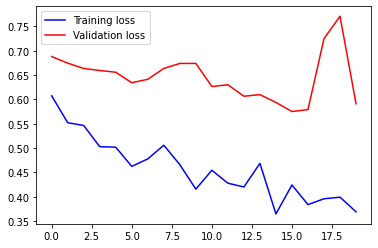

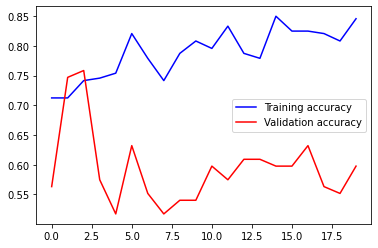

In [ ]:
plot_results(resnet_rmsprop_static_history)

In [ ]:
val_results(resnet_rmsprop_static)

Hockey Test Acc:  0.79 	Count:  79 
Movies Test Acc:  0.5 	Count:  5


In [ ]:
fvideo , flabels = extract_frames_difference(traindf)

Video Processed 250/250

In [ ]:
tvideo , tlabels = extract_frames_difference(valdf)

Video Processed 88/88

In [ ]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [ ]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

(240, 10, 160, 160, 3)
(240,)
(87, 10, 160, 160, 3)
(87,)


In [ ]:
hockey_video , hockey_labels = extract_frames_difference(dtframe,300,400)

Video Processed 100/100

In [ ]:
movies_video , movies_labels = extract_frames_difference(dtframe2,189,199)

Video Processed 10/10

In [ ]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

(100, 10, 160, 160, 3)
(100,)
(10, 10, 160, 160, 3)
(10,)


In [ ]:
'''
  Defining the second model which uses the difference between frames to classify the action
'''
def CNN_CONVLSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,3)

    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=input_shapes)
    
    model = Sequential()
    model.add(cnn)
    #model.add(TimeDistributed(Flatten()))

    
    model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
diff_vgg_rmsprop_retrain = CNN_CONVLSTM('Vgg19', 'RMSprop', True)
diff_vgg_rmsprop_retrain_history = diff_vgg_rmsprop_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
24/24 [==============================] - 15s 622ms/step - loss: 0.6479 - accuracy: 0.6708 - val_loss: 0.6626 - val_accuracy: 0.6897
Epoch 2/20
24/24 [==============================] - 14s 569ms/step - loss: 0.4375 - accuracy: 0.8000 - val_loss: 0.6565 - val_accuracy: 0.5517
Epoch 3/20
24/24 [==============================] - 14s 569ms/step - loss: 0.3273 - accuracy: 0.8667 - val_loss: 0.6280 - val_accuracy: 0.5057
Epoch 4/20
24/24 [==============================] - 14s 569ms/step - loss: 0.3628 - accuracy: 0.8417 - val_loss: 0.6329 - val_accuracy: 0.5057
Epoch 5/20
24/24 [==============================] - 14s 568ms/step - loss: 0.2520 - accuracy: 0.8875 - val_loss: 0.6334 - val_accuracy: 0.5057
Epoch 6/20
24/24 [==============================] - 14s 568ms/step - loss: 0.2623 - accuracy: 0.8917 - val_loss: 0.5852 - val_accuracy: 0.5517
Epoch 7/20
24/24 [==============================] - 14s 569ms/step - loss: 0.

In [ ]:
diff_vgg_rmsprop_retrain.save("ViolenceDetection.h5")

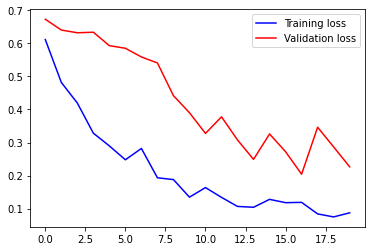

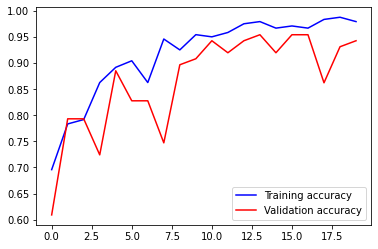

In [ ]:
plot_results(diff_vgg_rmsprop_retrain_history)

In [ ]:
val_results(diff_vgg_rmsprop_retrain)

Hockey Test Acc:  0.85 	Count:  85 
Movies Test Acc:  1.0 	Count:  10


In [ ]:
diff_vgg_rmsprop_static = CNN_CONVLSTM('Vgg19', 'RMSprop', False)
diff_vgg_rmsprop_static_history = diff_vgg_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 7s 307ms/step - loss: 0.7958 - accuracy: 0.5625 - val_loss: 0.7039 - val_accuracy: 0.4828
Epoch 2/20
24/24 [==============================] - 7s 289ms/step - loss: 0.7007 - accuracy: 0.6375 - val_loss: 0.6982 - val_accuracy: 0.4828
Epoch 3/20
24/24 [==============================] - 7s 290ms/step - loss: 0.6849 - accuracy: 0.6083 - val_loss: 0.6932 - val_accuracy: 0.5057
Epoch 4/20
24/24 [==============================] - 7s 290ms/step - loss: 0.6673 - accuracy: 0.6375 - val_loss: 0.6868 - val_accuracy: 0.5172
Epoch 5/20
24/24 [==============================] - 7s 290ms/step - loss: 0.5696 - accuracy: 0.7125 - val_loss: 0.6858 - val_accuracy: 0.5172
Epoch 6/20
24/24 [==============================] - 7s 290ms/step - loss: 0.4609 - accuracy: 0.7917 - val_loss: 0.6724 - val_accuracy: 0.5287
Epoch 7/20
24/24 [==============================] - 7s 290ms/step - loss: 0.4875 - accuracy: 0.7625 - val_loss: 0.6621 - val_accuracy: 0.5287
Epoch 

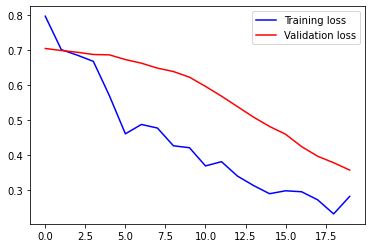

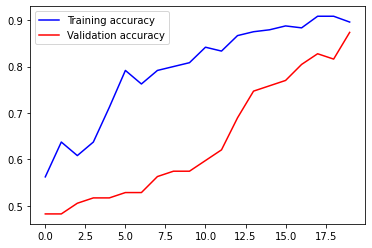

In [ ]:
plot_results(diff_vgg_rmsprop_static_history)

In [ ]:
val_results(diff_vgg_rmsprop_static)

Hockey Test Acc:  0.76 	Count:  76 
Movies Test Acc:  1.0 	Count:  10


In [ ]:
diff_vgg_adam_retrain = CNN_CONVLSTM('Vgg19', 'Adam', True)
diff_vgg_adam_retrain_history = diff_vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
24/24 [==============================] - 16s 685ms/step - loss: 0.7708 - accuracy: 0.5500 - val_loss: 0.6558 - val_accuracy: 0.7701
Epoch 2/20
24/24 [==============================] - 16s 667ms/step - loss: 0.5318 - accuracy: 0.7292 - val_loss: 0.6675 - val_accuracy: 0.5057
Epoch 3/20
24/24 [==============================] - 16s 667ms/step - loss: 0.3979 - accuracy: 0.8083 - val_loss: 0.6982 - val_accuracy: 0.5057
Epoch 4/20
24/24 [==============================] - 16s 667ms/step - loss: 0.3150 - accuracy: 0.8833 - val_loss: 0.7642 - val_accuracy: 0.5057
Epoch 5/20
24/24 [==============================] - 16s 668ms/step - loss: 0.3076 - accuracy: 0.9042 - val_loss: 0.7271 - val_accuracy: 0.5057
Epoch 6/20
24/24 [==============================] - 16s 668ms/step - loss: 0.3237 - accuracy: 0.8625 - val_loss: 0.7139 - val_accuracy: 0.5057
Epoch 7/20
24/24 [==============================] - 16s 666ms/step - loss: 0.2487 - accuracy: 0.9167 - val_loss: 0.7360 - val_accuracy: 0.5057

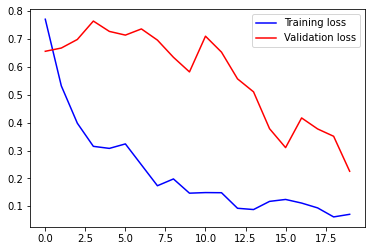

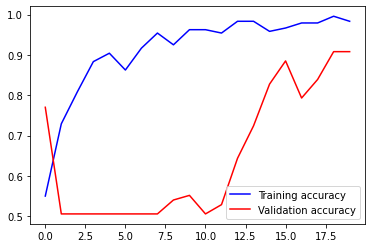

In [ ]:
plot_results(diff_vgg_adam_retrain_history)

In [ ]:
val_results(diff_vgg_adam_retrain)

Hockey Test Acc:  0.74 	Count:  74 
Movies Test Acc:  1.0 	Count:  10


In [ ]:
diff_resnet_rmsprop_retrain = CNN_CONVLSTM('Resnet', 'RMSprop', True)
diff_resnet_rmsprop_retrain_history = diff_resnet_rmsprop_retrain.fit(fvideo,flabels, batch_size=20, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
12/12 [==============================] - 10s 819ms/step - loss: 0.8767 - accuracy: 0.5208 - val_loss: 0.7396 - val_accuracy: 0.4943
Epoch 2/20
12/12 [==============================] - 8s 703ms/step - loss: 0.6773 - accuracy: 0.6333 - val_loss: 0.7207 - val_accuracy: 0.3793
Epoch 3/20
12/12 [==============================] - 8s 703ms/step - loss: 0.4418 - accuracy: 0.7792 - val_loss: 0.7048 - val_accuracy: 0.3103
Epoch 4/20
12/12 [==============================] - 8s 703ms/step - loss: 0.4091 - accuracy: 0.8125 - val_loss: 0.7058 - val_accuracy: 0.5057
Epoch 5/20
12/12 [==============================] - 8s 703ms/step - loss: 0.3106 - accuracy: 0.8708 - val_loss: 0.7034 - val_accuracy: 0.4943
Epoch 6/20
12/12 [==============================] - 8s 702ms/step - loss: 0.2712 - accuracy: 0.9042 - val_loss: 0.7042 - val_accuracy: 0.4828
Epoch 7/20
12/12 [==============================] - 8s 703ms/step - loss: 0.2083 - accuracy: 0.9417 - val_loss: 0.7065 - val_accuracy: 0.4943
Epoch

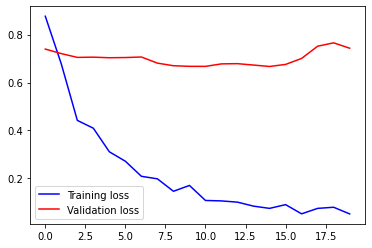

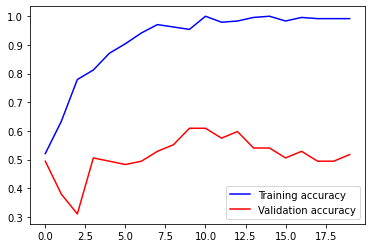

In [ ]:
plot_results(diff_resnet_rmsprop_retrain_history)

In [ ]:
val_results(diff_resnet_rmsprop_retrain)

Hockey Test Acc:  0.54 	Count:  54 
Movies Test Acc:  0.5 	Count:  5
